<a href="https://colab.research.google.com/github/ritikraj6120/bert-ensembling/blob/main/Copy_of_BERT_Word_Embeddings_using_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction



# 1. Loading Pre-Trained BERT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/imdb_dataset

/content/drive/MyDrive/Colab Notebooks/imdb_dataset


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm().pandas()

0it [00:00, ?it/s]

In [ ]:
wholeset=pd.read_csv("cleaned_imdb_datset.csv")

In [ ]:
df=wholeset.head(100)

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.2 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# text_list = ['hello world and bye world!','hello world!']

In [ ]:
# max_len=0
# for ind in df.index:
#     tokens = tokenizer.tokenize(df['content'][ind])
#     max_len=max(max_len,len(tokens)+2)
#     print(len(tokens))

170
491
78
315
328


In [ ]:
content_list=df["content"].tolist()

In [ ]:
token = tokenizer.__call__(content_list,add_special_tokens=True,padding='max_length',max_length=128,truncation = True,return_tensors='pt')

In [ ]:
token.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
# token.input_ids[0]

tensor([  101,  2821,  2053,  2063,  2028,  1997,  2122,  2886,  1997,  1996,
         2900,  2229,  5745,  2611,  9587,  5737,  1045,  2123,  1056,  2130,
         2128,  4168, 14905,  2129, 23624,  1045,  2310,  2464,  2089,  2497,
         2009,  5271,  2021,  2025,  2000,  2033,  2025, 11228,  2072,  2012,
         2035,  1996,  2900,  2229,  5469,  9587,  5737,  2024,  2031,  2042,
         2310,  3089,  2714,  8254,  2278,  1996,  2034,  2028,  1997,  2122,
         2036,  1996,  4139,  1997,  1996,  4845,  1045,  2031,  2464,  2008,
         4139,  2104,  3496,  2061, 23624,  2051,  1999,  2061, 23624,  5469,
         9587,  5737,  3526, 20846,  3496,  2003,  2036,  2025,  2232,  2047,
         1996,  3689,  2102,  1997,  1996,  3124,  2131,  2718,  2011,  1037,
         3345, 17704, 11891,  1045,  2812,  2009,  3768,  2035,  3689,  2102,
         7929, 16215,  2072,  2003,  2005,  4845,  2403,  2385,  2040,  4952,
         2000,  2900,  2229,  2600,  1998,  2228,  2027,   102])

In [ ]:
# Load pre-trained model (weights)
from transformers import BertModel
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()


In [ ]:
import torch

Next, let's evaluate BERT on our example text, and fetch the hidden states of the network!

*Side note: `torch.no_grad` tells PyTorch not to construct the compute graph during this forward pass (since we won't be running backprop here)--this just reduces memory consumption and speeds things up a little.*


In [ ]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    outputs = model(**token)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

## 3.2. Understanding the Output



The full set of hidden states for this model, stored in the object `hidden_states`, is a little dizzying. This object has four dimensions, in the following order:

1. The layer number (13 layers)
2. The batch number (1 sentence)
3. The word / token number (22 tokens in our sentence)
4. The hidden unit / feature number (768 features)

Wait, 13 layers? Doesn't BERT only have 12? It's 13 because the first element is the input embeddings, the rest is the outputs of each of BERT's 12 layers. 

That’s 219,648 unique values just to represent our one sentence! 

The second dimension, the batch size, is used when submitting multiple sentences to the model at once; here, though, we just have one example sentence.

In [ ]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1000
Number of tokens: 128
Number of hidden units: 768


Grouping the values by layer makes sense for the model, but for our purposes we want it grouped by token. 

Current dimensions:

`[# layers, # batches, # tokens, # features]`

Desired dimensions:

`[# tokens, # layers, # features]`

Luckily, PyTorch includes the `permute` function for easily rearranging the dimensions of a tensor. 

However, the first dimension is currently a Python list! 

In [ ]:
# `hidden_states` is a Python list.
print('Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1000, 128, 768])


Let's combine the layers to make this one whole big tensor.

In [ ]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)
token_embeddings.size()

torch.Size([13, 100, 128, 768])

In [ ]:
permuted_token_embeddings = token_embeddings.permute(1,0,2,3)
print(type(permuted_token_embeddings))
permuted_token_embeddings.size()

<class 'torch.Tensor'>


torch.Size([100, 13, 128, 768])

In [ ]:
np.save('permuted_token_embeddings_100_torch_date_27-04-2023.npy', permuted_token_embeddings)

### Sentence Vectors



To get a single vector for our entire sentence we have multiple application-dependent strategies, but a simple approach is to average the second to last hiden layer of each token producing a single 768 length vector.

In [ ]:
import numpy as np
# a=[[1.0,2,3],
#    [4,5,6]
#    ]
# arr = np.array(a)
# t = torch.from_numpy(arr)
# print(t)
# sentence_embedding = torch.mean(t, dim=0)
# print(len(sentence_embedding))
# # Calculate the average of all 22 token vectors.
# # sentence_embedding = torch.mean(token_vecs, dim=0)

In [ ]:
rows=len(permuted_token_embeddings)
sentence_embedding = np.zeros((rows, 768), dtype=float)
for i in range(rows):
  hidden_states = permuted_token_embeddings[i] # 13, 6, 768
  # `second_last_hidden_state` is a tensor with shape [6 x 768]
  second_last_hidden_state = hidden_states[-2]
  # Calculate the average of all 6 token vectors.
  sentence_embedding[i]=torch.mean(second_last_hidden_state, dim=0).numpy()

In [ ]:
print ("Our final sentence embedding vector of shape:", type(sentence_embedding))

Our final sentence embedding vector of shape: <class 'numpy.ndarray'>


In [ ]:
np.save('embeddings_1000_torch_date_25-04-2023.npy', sentence_embedding)

In [ ]:
sentence_embedding = np.load('embeddings_1000_torch_date_25-04-2023.npy')

In [ ]:
from sklearn.model_selection import train_test_split
# rating=t = tf.convert_to_tensor(df["rating"])
# print(type(rating))
train_review, test_review, train_rating, test_rating = train_test_split(sentence_embedding, df['rating'] , test_size=0.2, random_state=42)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Embedding, Conv1D, Activation, GlobalMaxPool1D, BatchNormalization,AveragePooling1D,
                          Concatenate, LSTM,GRU , Flatten, Dropout, Dense)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.utils import to_categorical, Sequence, plot_model
from tensorflow.keras.layers import Bidirectional

In [ ]:
# reshaping input data for lstm, gru, bilstm into 3d array as these models require 3d input array
train_review = tf.reshape(train_review, shape=(tf.shape(train_review)[0], 1, -1))
test_review = tf.reshape(test_review, shape=(tf.shape(test_review)[0], 1, -1))

# **LSTM MODEL**

In [ ]:
train_review.shape

TensorShape([800, 1, 768])

In [ ]:
max_length=128
num_classes=2
embed_dim=768
num_words=30000
#  create a sample input tensor with 768 input dimensions
input_tensor = tf.keras.Input(shape=(768,))
# shape is (None,768)

# reshape the input tensor to have 1 timestep
reshaped_input = tf.reshape(input_tensor, shape=(-1, 1, 768))
# shape is (None,1,768)

# pass the reshaped input tensor to the LSTM layer
# output_tensor = lstm_layer(reshaped_input)

# sequence_input = Input(shape=(embed_dim),name='input_layer')
lstm1 = LSTM(500, return_sequences=True)(reshaped_input)
drop3 = Dropout(0.2)(lstm1)
lstm2 = LSTM(200)(drop3)
drop4 = Dropout(0.2)(lstm2)
out3 = Dense(num_classes, activation='softmax',name='last_dense_layer')(drop4)
lstm_model = Model(reshaped_input,out3)
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()
# out3_output = lstm_model.get_layer('last_dense_layer')(lstm_model.layers[-2].output)
# out3_model = Model(inputs=lstm_model.input, outputs=out3_output)
# Define the number of time steps and the number of features
# n_timesteps = 10
# n_features = 1

# Define the LSTM model
# model = Sequential()
# model.add(LSTM(50, input_shape=(n_timesteps, n_features)))
# model.add(Dense(1))
# model.compile(loss='mse', optimizer='adam')

# # Train the LSTM model
# model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 768)]          0         
                                                                 
 lstm (LSTM)                 (None, 1, 500)            2538000   
                                                                 
 dropout (Dropout)           (None, 1, 500)            0         
                                                                 
 lstm_1 (LSTM)               (None, 200)               560800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 last_dense_layer (Dense)    (None, 2)                 402       
                                                                 
Total params: 3,099,202
Trainable params: 3,099,202
Non-train

In [ ]:
lstm_history = lstm_model.fit(train_review, train_rating, batch_size=64,verbose=1,epochs=5, 
                            validation_split=0.1)

Epoch 1/5
12/12 [==============================] - 7s 161ms/step - loss: 0.6854 - accuracy: 0.5208 - val_loss: 0.6674 - val_accuracy: 0.6250
Epoch 2/5
12/12 [==============================] - 1s 71ms/step - loss: 0.6348 - accuracy: 0.6444 - val_loss: 0.7027 - val_accuracy: 0.5875
Epoch 3/5
12/12 [==============================] - 1s 74ms/step - loss: 0.5684 - accuracy: 0.7111 - val_loss: 0.6250 - val_accuracy: 0.6375
Epoch 4/5
12/12 [==============================] - 1s 99ms/step - loss: 0.4998 - accuracy: 0.7458 - val_loss: 0.6587 - val_accuracy: 0.6500
Epoch 5/5
12/12 [==============================] - 1s 107ms/step - loss: 0.4642 - accuracy: 0.7708 - val_loss: 0.6246 - val_accuracy: 0.6125


In [ ]:
# access training loss
# print(lstm_history.history)
lstm_train_loss = lstm_history.history['loss']

# access training accuracy
lstm_train_accuracy = lstm_history.history['accuracy']

# access validation loss (if validation data was provided)
lstm_val_loss = lstm_history.history['val_loss']

# access validation accuracy (if validation data was provided)
lstm_val_accuracy = lstm_history.history['val_accuracy']

In [ ]:
lstm_test_loss,lstm_test_accuracy = lstm_model.evaluate(x=test_review, y=test_rating, batch_size=64 ,verbose=1)

4/4 [==============================] - 0s 14ms/step - loss: 0.5605 - accuracy: 0.7250


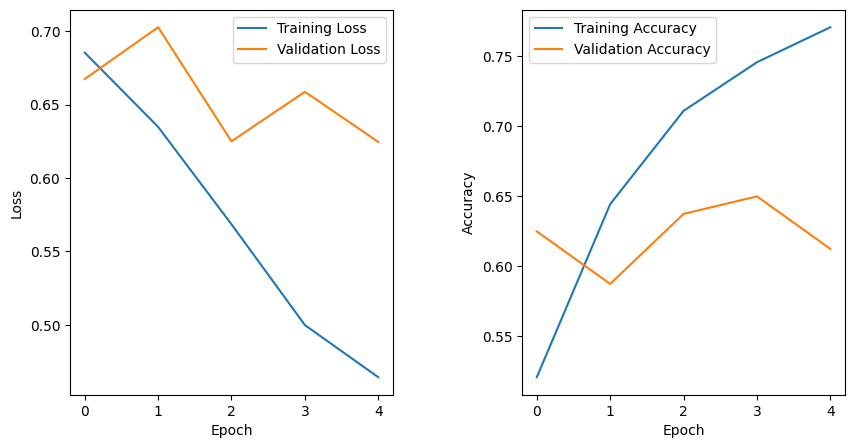

In [ ]:
import matplotlib.pyplot as plt
# create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# plot training and validation loss over each epoch
ax1.plot(lstm_train_loss, label='Training Loss')
ax1.plot(lstm_val_loss, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# plot training and validation accuracy over each epoch
ax2.plot(lstm_train_accuracy, label='Training Accuracy')
ax2.plot(lstm_val_accuracy, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# show the figure
plt.show()


# **Now using Gru**

In [ ]:
gru1 = GRU (500, return_sequences=True)(reshaped_input)
drop3 = Dropout(0.2)(gru1)
gru2 = LSTM(200)(drop3)
drop4 = Dropout(0.2)(gru2)
out3 = Dense(num_classes, activation='softmax')(drop4)
gru_model = Model(reshaped_input,out3)
gru_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 768)]          0         
                                                                 
 gru (GRU)                   (None, 1, 500)            1905000   
                                                                 
 dropout_2 (Dropout)         (None, 1, 500)            0         
                                                                 
 lstm_2 (LSTM)               (None, 200)               560800    
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 2,466,202
Trainable params: 2,466,202
Non-tra

In [ ]:
gru_history = gru_model.fit(train_review, train_rating, batch_size=64,verbose=1,epochs=5,validation_split=0.1)

Epoch 1/5
12/12 [==============================] - 6s 139ms/step - loss: 0.7061 - accuracy: 0.5139 - val_loss: 0.7378 - val_accuracy: 0.4875
Epoch 2/5
12/12 [==============================] - 1s 60ms/step - loss: 0.6786 - accuracy: 0.5681 - val_loss: 0.6803 - val_accuracy: 0.5500
Epoch 3/5
12/12 [==============================] - 1s 89ms/step - loss: 0.5958 - accuracy: 0.6972 - val_loss: 0.6740 - val_accuracy: 0.5875
Epoch 4/5
12/12 [==============================] - 1s 86ms/step - loss: 0.5075 - accuracy: 0.7514 - val_loss: 0.6551 - val_accuracy: 0.6375
Epoch 5/5
12/12 [==============================] - 1s 85ms/step - loss: 0.5069 - accuracy: 0.7542 - val_loss: 0.6414 - val_accuracy: 0.6125


In [ ]:
gru_train_loss = gru_history.history['loss']
gru_train_accuracy = gru_history.history['accuracy']
gru_val_loss = gru_history.history['val_loss']
gru_val_accuracy = gru_history.history['val_accuracy']

In [ ]:
gru_test_loss,gru_test_accuracy=gru_model.evaluate(x=test_review, y=test_rating, batch_size=64 ,verbose=1)

4/4 [==============================] - 0s 12ms/step - loss: 0.5459 - accuracy: 0.7650


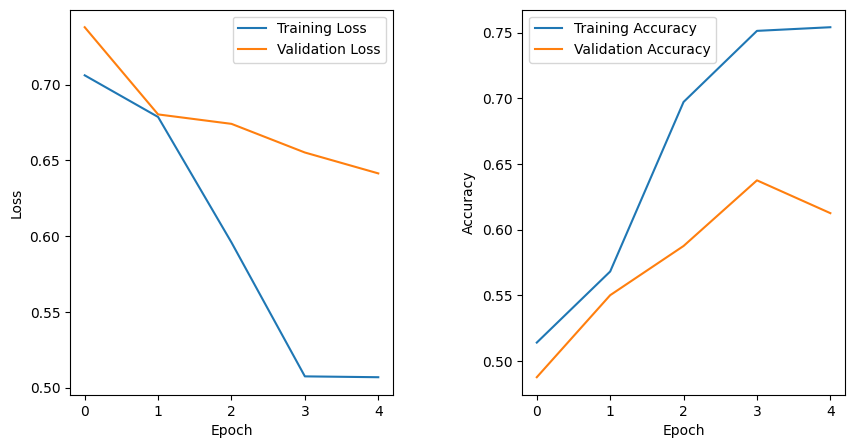

In [ ]:
# create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# plot training and validation loss over each epoch
ax1.plot(gru_train_loss, label='Training Loss')
ax1.plot(gru_val_loss, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# plot training and validation accuracy over each epoch
ax2.plot(gru_train_accuracy, label='Training Accuracy')
ax2.plot(gru_val_accuracy, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# show the figure
plt.show()


In [ ]:
max_length=128
num_classes=2
embed_dim=768
num_words=30000
#  create a sample input tensor with 768 input dimensions
input_tensor = tf.keras.Input(shape=(768,))

# reshape the input tensor to have 1 timestep
reshaped_input = tf.reshape(input_tensor, shape=(-1, 1, 768))
bilstm1 = Bidirectional(LSTM(500, return_sequences=True))(reshaped_input)
drop3 = Dropout(0.2)(bilstm1)
bilstm2 = Bidirectional(LSTM(200))(drop3)
drop4 = Dropout(0.2)(bilstm2)
out3 = Dense(num_classes, activation='softmax',name='last_dense_layer')(drop4)
bilstm_model = Model(reshaped_input,out3)
bilstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1, 768)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 1000)          5076000   
 l)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 1, 1000)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 400)              1921600   
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 400)               0         
                                                                 
 last_dense_layer (Dense)    (None, 2)                 802 

TensorShape([None, 1, 768])

In [ ]:
bilstm_history = bilstm_model.fit(train_review, train_rating, batch_size=64,verbose=1,epochs=5, 
                            validation_split=0.1)

Epoch 1/5
12/12 [==============================] - 13s 306ms/step - loss: 0.6831 - accuracy: 0.5472 - val_loss: 0.6589 - val_accuracy: 0.6875
Epoch 2/5
12/12 [==============================] - 1s 124ms/step - loss: 0.5963 - accuracy: 0.7111 - val_loss: 0.6687 - val_accuracy: 0.6000
Epoch 3/5
12/12 [==============================] - 2s 149ms/step - loss: 0.5197 - accuracy: 0.7375 - val_loss: 0.7261 - val_accuracy: 0.6375
Epoch 4/5
12/12 [==============================] - 2s 150ms/step - loss: 0.5142 - accuracy: 0.7292 - val_loss: 0.7677 - val_accuracy: 0.6125
Epoch 5/5
12/12 [==============================] - 2s 201ms/step - loss: 0.4692 - accuracy: 0.7847 - val_loss: 0.6305 - val_accuracy: 0.6375


In [ ]:
# access training loss
bilstm_train_loss = bilstm_history.history['loss']
bilstm_train_accuracy = bilstm_history.history['accuracy']
bilstm_val_loss = bilstm_history.history['val_loss']
bilstm_val_accuracy = bilstm_history.history['val_accuracy']

In [ ]:
bilstm_test_loss,bilstm_test_accuracy=bilstm_model.evaluate(x=test_review, y=test_rating, batch_size=64 ,verbose=1)

4/4 [==============================] - 0s 45ms/step - loss: 0.5795 - accuracy: 0.7050


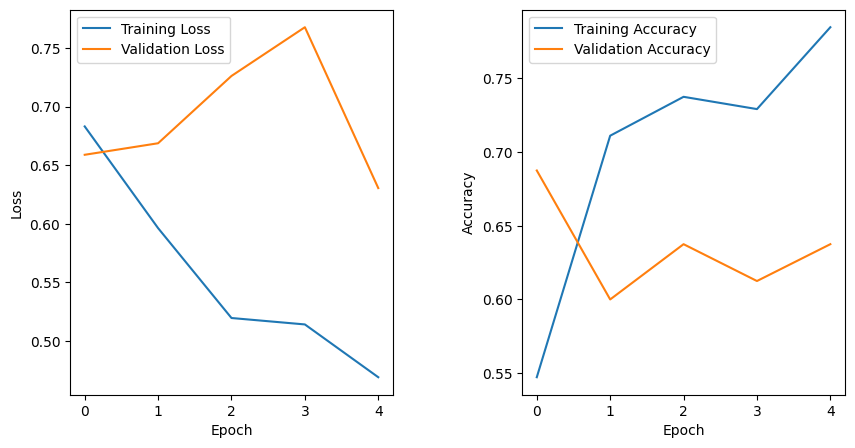

In [ ]:
# create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# plot training and validation loss over each epoch
ax1.plot(bilstm_train_loss, label='Training Loss')
ax1.plot(bilstm_val_loss, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# plot training and validation accuracy over each epoch
ax2.plot(bilstm_train_accuracy, label='Training Accuracy')
ax2.plot(bilstm_val_accuracy, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# show the figure
plt.show()

# **GENERATING WORD EMBEDDING PER SENTENCE FOR CNN**

As an alternative method, let’s try creating the word vectors by summing together the last four layers.

In [ ]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in permuted_token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec.numpy())

In [ ]:
print ('Shape is: %d x %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0]), len(token_vecs_sum[0][0])))

Shape is: 100 x 128 x 768


In [ ]:
token_vecs_sum_numpy=np.array(token_vecs_sum)

In [ ]:
from sklearn.model_selection import train_test_split
# rating=t = tf.convert_to_tensor(df["rating"])
# print(type(rating))
cnn_train_review,cnn_test_review, cnn_train_rating, cnn_test_rating = train_test_split(token_vecs_sum_numpy, df['rating'] , test_size=0.2, random_state=42)

In [ ]:
# sentences=len(token_vecs_sum)
# input_shape = (sentences, 128, 768)
# x = tf.random.normal(input_shape)
# print(x.shape)
# abc = tf.keras.Input(shape=(128,768))
x=Input(shape=(128,768))
conv1 = Conv1D(16, 3, activation='relu',padding='same')(x)
avg1=AveragePooling1D(pool_size=2,strides=2)(conv1)
conv2 =Conv1D(32, 5, activation='relu',padding='same')(avg1)
avg2=AveragePooling1D(pool_size=2,strides=2)(conv2)
conv2 =Conv1D(64,7, activation='relu',padding='same',)(avg1)
avg2=AveragePooling1D(pool_size=2,strides=2)(conv2)
# Flatten the output
flatten = Flatten()(avg2)
fc1 = Dense(128, activation='relu')(flatten)
fc1 = Dropout(0.5)(fc1)
# Add a final output layer
output_layer = Dense(2, activation='softmax')(fc1)
# Create the model
cnn_model = Model(inputs=x, outputs=output_layer)

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
# model.summary()


In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
cnn_history = cnn_model.fit(cnn_train_review, cnn_train_rating,verbose=1,epochs=5, 
                            validation_split=0.1)

Epoch 1/5


/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 1s 223ms/step - loss: 0.8177 - accuracy: 0.6111 - val_loss: 1.0835 - val_accuracy: 0.3750
Epoch 2/5
3/3 [==============================] - 1s 200ms/step - loss: 0.5456 - accuracy: 0.7222 - val_loss: 0.7198 - val_accuracy: 0.3750
Epoch 3/5
3/3 [==============================] - 1s 206ms/step - loss: 0.4958 - accuracy: 0.7500 - val_loss: 0.7941 - val_accuracy: 0.5000
Epoch 4/5
3/3 [==============================] - 1s 201ms/step - loss: 0.4149 - accuracy: 0.8056 - val_loss: 0.7250 - val_accuracy: 0.3750
Epoch 5/5
3/3 [==============================] - 1s 196ms/step - loss: 0.2144 - accuracy: 0.9583 - val_loss: 0.8768 - val_accuracy: 0.3750


# **Multi-Scale Cnn**

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, concatenate, Flatten, Dense, Dropout

# Define the input shape
input_shape = (num_sentences, 768)

# Define the input layer
input_layer = Input(shape=input_shape)

# Define the first convolutional block
conv1_1 = Conv1D(32, 3, activation='relu', padding='same')(input_layer)
conv1_1 = MaxPooling1D(pool_size=2)(conv1_1)

# Define the second convolutional block
conv1_2 = Conv1D(64, 3, activation='relu', padding='same')(conv1_1)
conv1_2 = MaxPooling1D(pool_size=2)(conv1_2)

# Define the third convolutional block
conv1_3 = Conv1D(128, 3, activation='relu', padding='same')(conv1_2)
conv1_3 = MaxPooling1D(pool_size=2)(conv1_3)

# Define the fourth convolutional block
conv1_4 = Conv1D(256, 3, activation='relu', padding='same')(conv1_3)
conv1_4 = MaxPooling1D(pool_size=2)(conv1_4)

# Define the multi-scale block
scale1 = Conv1D(512, 1, activation='relu', padding='same')(conv1_4)
scale2 = Conv1D(512, 3, activation='relu', padding='same')(conv1_4)
scale3 = Conv1D(512, 5, activation='relu', padding='same')(conv1_4)
concat = concatenate([scale1, scale2, scale3])

# Flatten the output
flatten = Flatten()(concat)

# Add a fully connected layer
fc1 = Dense(1024, activation='relu')(flatten)
fc1 = Dropout(0.5)(fc1)

# Add another fully connected layer
fc2 = Dense(512, activation='relu')(fc1)
fc2 = Dropout(0.5)(fc2)

# Add a final output layer
output_layer = Dense(1, activation='sigmoid')(fc2)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='sigmoid', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 768, 32)      128         ['input_2[0][0]']                
                                                                                                  
 max_pooling1d_4 (MaxPooling1D)  (None, 384, 32)     0           ['conv1d_7[0][0]']               
                                                                                                  
 conv1d_8 (Conv1D)              (None, 384, 64)      6208        ['max_pooling1d_4[0][0]']        
                                                                                            

In [ ]:
input_tensor = tf.keras.Input(shape=(None, 768))
input_tensor

<KerasTensor: shape=(None, None, 768) dtype=float32 (created by layer 'input_8')>

In [ ]:
mcnn_model_history = mcnn_model.fit(train_review, train_rating, batch_size=64,verbose=1,epochs=5, 
                            validation_split=0.1)

NameError: ignored

# **Ensembling Model**

In [ ]:
import statistics
import numpy as np

In [ ]:
lstm_model_predictions = lstm_model.predict(test_review,verbose=1)

7/7 [==============================] - 1s 19ms/step


In [ ]:
lstm_model_pred=[]
for i in lstm_model_predictions:
  if(i[0]>i[1]):
    lstm_model_pred.append(0)
  else:
    lstm_model_pred.append(1)

In [ ]:
gru_model_predictions=gru_model.predict(test_review,verbose=1)

7/7 [==============================] - 1s 11ms/step


In [ ]:
gru_model_pred=[]
for i in gru_model_predictions:
  if(i[0]>i[1]):
    gru_model_pred.append(0)
  else:
    gru_model_pred.append(1)

In [ ]:
bilstm_model_predictions = bilstm_model.predict(test_review,verbose=1)

7/7 [==============================] - 2s 17ms/step


In [ ]:
bilstm_model_pred=[]
for i in bilstm_model_predictions:
  if(i[0]>i[1]):
    bilstm_model_pred.append(0)
  else:
    bilstm_model_pred.append(1)

In [ ]:
final_pred = []

In [ ]:
for i in range(0, len(test_review)):
      final_pred.append(statistics.mode([lstm_model_pred[i], 
                                         gru_model_pred[i],
                                         bilstm_model_pred[i]]))

# **Finding individual accuracy before ensembling**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy, precision, recall, and F1 score for each model
lstm_model_accuracy = accuracy_score(test_rating, lstm_model_pred)
gru_model_accuracy = accuracy_score(test_rating, gru_model_pred)
bilstm_model_accuracy = accuracy_score(test_rating, bilstm_model_pred)

lstm_model_precision = precision_score(test_rating, lstm_model_pred)
gru_model_precision = precision_score(test_rating, gru_model_pred)
bilstm_model_precision = precision_score(test_rating, bilstm_model_pred)

lstm_model_recall = recall_score(test_rating, lstm_model_pred)
gru_model_recall = recall_score(test_rating, gru_model_pred)
bilstm_model_recall = recall_score(test_rating, bilstm_model_pred)

lstm_model_f1_score = f1_score(test_rating, lstm_model_pred)
gru_model_f1_score = f1_score(test_rating, gru_model_pred)
bilstm_model_f1_score = f1_score(test_rating, bilstm_model_pred)


# **Finding Accuracy accuracy ensembling**

In [ ]:
# Assume y_pred and y_true are numpy arrays of predicted and true labels, respectively
accuracy_ensemble = accuracy_score(test_rating, final_pred)
precision_ensemble = precision_score(test_rating,final_pred)
recall_ensemble = recall_score(test_rating,final_pred)
f1_score_ensemble = f1_score(test_rating,final_pred)

# **Showing performance**

In [ ]:
# Define the model names and performance metrics
models = ["LSTM MODEL", "GRU MODEL", "BiLSTM MODEL", "Ensemble Model"]
accuracy = [lstm_model_accuracy, gru_model_accuracy, bilstm_model_accuracy, accuracy_ensemble]
precision = [lstm_model_precision, gru_model_precision, bilstm_model_precision, precision_ensemble]
recall = [lstm_model_recall, gru_model_recall, bilstm_model_recall, recall_ensemble]
f1_score = [lstm_model_f1_score, gru_model_f1_score, bilstm_model_f1_score, f1_score_ensemble]

# Print the table headers
print("{:<15} {:<15} {:<15} {:<15} {:<15}".format("Model", "Accuracy", "Precision", "Recall", "F1 Score"))

# Print the table rows
for i in range(len(models)):
    print("{:<15} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f}".format(models[i], accuracy[i], precision[i], recall[i], f1_score[i]))

Model           Accuracy        Precision       Recall          F1 Score       
LSTM MODEL      0.7250          0.7674          0.6535          0.7059         
GRU MODEL       0.7650          0.7500          0.8020          0.7751         
BiLSTM MODEL    0.7050          0.7333          0.6535          0.6911         
Ensemble Model  0.7200          0.7419          0.6832          0.7113         
